In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


In [2]:
subset_0_dir='/kaggle/input/assign2/subsets_train/subsets_train/subset_0'
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])
image_subset_0= datasets.ImageFolder(root=subset_0_dir, transform=data_transform)
from torch.utils.data import DataLoader
batch_size = 32  # Adjust the batch size as needed
dataloader_subset_0 = DataLoader(image_subset_0, batch_size=batch_size, shuffle=True)

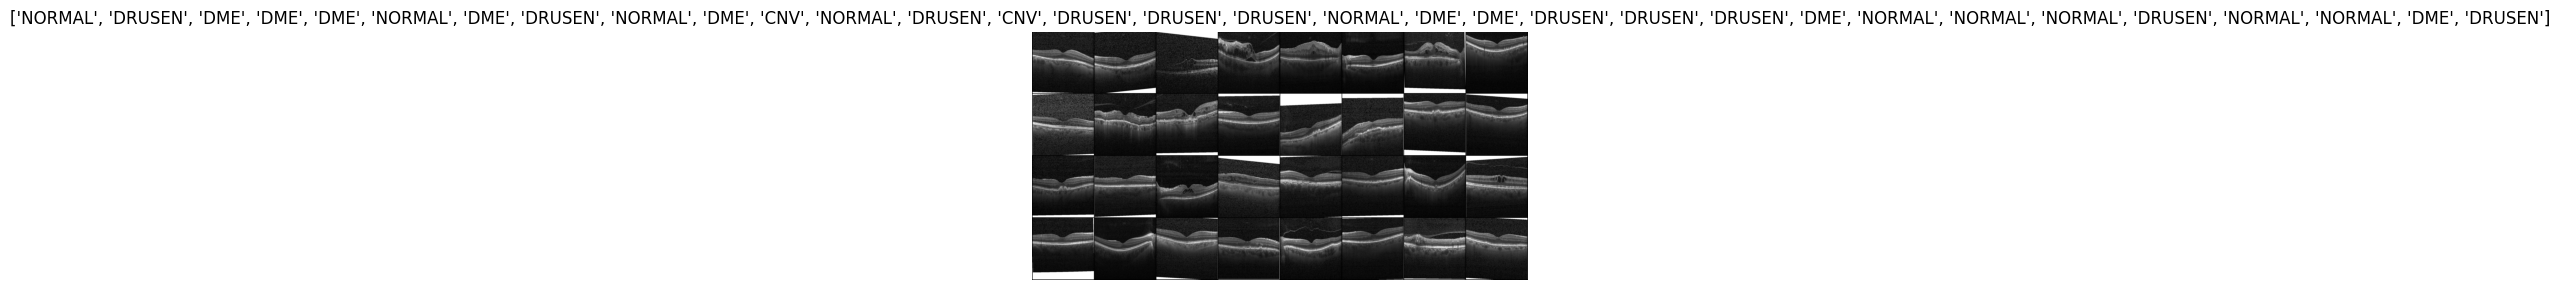

In [3]:
class_names=image_subset_0.classes
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloader_subset_0 ))
show_databatch(inputs, classes)

In [4]:
vgg16 = models.vgg16()
vgg16.load_state_dict(torch.load("/kaggle/input/pre-model/vgg16-397923af.pth"))
print(vgg16.classifier[6].out_features) # 1000


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 4 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [5]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [6]:
import copy
import time
import torch
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
# Define your train_model function
def train_model(vgg, criterion, optimizer, scheduler, num_epochs, dataloader):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)

        # Training phase
        vgg.train()
        running_loss = 0.0
        corrects = 0
        total_samples = 0

        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = vgg(inputs)
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += torch.sum(preds == labels.data)
            total_samples += labels.size(0)

        epoch_loss = running_loss / total_samples
        epoch_acc = corrects.double() / total_samples

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

        # Deep copy the model if it has the best accuracy
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(vgg.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.4f}'.format(best_acc))

    # Load best model weights
    vgg.load_state_dict(best_model_wts)
    return vgg

# Loop through subsets and train the model
for i in range(3):
    subset_dir = f'/kaggle/input/assign2/subsets_train/subsets_train/subset_{i}'
    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    image_subset = datasets.ImageFolder(root=subset_dir, transform=data_transform)
    dataloader = DataLoader(image_subset, batch_size=32, shuffle=True)
    
    # Call train_model function with the vgg16 instance
    vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=10, dataloader=dataloader)
    
    # Save the trained model
    torch.save(vgg16.state_dict(), f'model{i}.pt')

Epoch 0/10
----------
Loss: 0.6961 Acc: 0.7037

Epoch 1/10
----------
Loss: 0.2959 Acc: 0.9012

Epoch 2/10
----------
Loss: 0.2237 Acc: 0.9253

Epoch 3/10
----------
Loss: 0.1765 Acc: 0.9385

Epoch 4/10
----------
Loss: 0.1328 Acc: 0.9525

Epoch 5/10
----------
Loss: 0.0972 Acc: 0.9683

Epoch 6/10
----------
Loss: 0.0661 Acc: 0.9780

Epoch 7/10
----------
Loss: 0.0419 Acc: 0.9860

Epoch 8/10
----------
Loss: 0.0420 Acc: 0.9853

Epoch 9/10
----------
Loss: 0.0425 Acc: 0.9853

Training complete in 13m 34s
Best val Acc: 0.9860
Epoch 0/10
----------
Loss: 0.2170 Acc: 0.9305

Epoch 1/10
----------
Loss: 0.1248 Acc: 0.9593

Epoch 2/10
----------
Loss: 0.1041 Acc: 0.9665

Epoch 3/10
----------
Loss: 0.0663 Acc: 0.9808

Epoch 4/10
----------
Loss: 0.0471 Acc: 0.9830

Epoch 5/10
----------
Loss: 0.0278 Acc: 0.9910

Epoch 6/10
----------
Loss: 0.0197 Acc: 0.9915

Epoch 7/10
----------
Loss: 0.0162 Acc: 0.9950

Epoch 8/10
----------
Loss: 0.0134 Acc: 0.9962

Epoch 9/10
----------
Loss: 0.0274 Acc

In [8]:
validation_dir_0='/kaggle/input/assign2/validation/validation'
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a consistent size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])
image_validation_0= datasets.ImageFolder(root=validation_dir_0, transform=data_transform)
from torch.utils.data import DataLoader
batch_size = 32  # Adjust the batch size as needed
dataloader_validation_0 = DataLoader(image_validation_0, batch_size=batch_size, shuffle=True)

In [13]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def evaluate_model(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            all_probs.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_probs)
    micro_f1 = f1_score(all_labels, all_probs, average='micro')
    average_recall = recall_score(all_labels, all_probs, average='weighted')
    precision = precision_score(all_labels, all_probs, average='micro')

    return accuracy, micro_f1, average_recall, precision

# Evaluate the model on the validation set
for i in range(3):
    import torch
    import torch.nn as nn
    from torchvision import models

    class CustomVGG16(nn.Module):
        def __init__(self, num_classes):
            super(CustomVGG16, self).__init__()
            # Load the pre-trained VGG16 model
            vgg16 = models.vgg16(pretrained=False)
            # Extract the features part of VGG16 (all layers except classifier)
            self.features = nn.Sequential(*list(vgg16.features.children()))
            # Freeze the pre-trained layers
            for param in self.features.parameters():
                param.requires_grad = False
            # Add custom classifier layers
            self.classifier = nn.Sequential(
                nn.Linear(512 * 7 * 7, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
            )

        def forward(self, x):
            x = self.features(x)
            x = x.view(x.size(0), -1)
            x = self.classifier(x)
            return x


    # Check if CUDA (GPU support) is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize the custom VGG16 model
    
    vgg16_custom = CustomVGG16(num_classes=4).to(device)

    # Load the saved state dictionary into the custom model
    model_path = f'model{i}.pt'  # Replace with the actual path to your saved model file
    vgg16_custom.load_state_dict(torch.load(model_path, map_location=device))

    # Define your data transform (ensure it matches the transform used during training)
    data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    accuracy_0, micro_f1_0, average_recall_0, precision_0 = evaluate_model(vgg16_custom, dataloader_validation_0)

    print(f'Accuracy of subset_{i}: {accuracy_0:.4f}')
    print(f'Micro F1 of subset_{i}: {micro_f1_0:.4f}')
    print(f'Average Recall of subset_{i}: {average_recall_0:.4f}')
    print(f'Precision of subset_{i}: {precision_0:.4f}')

Accuracy of subset_0: 0.9325
Micro F1 of subset_0: 0.9325
Average Recall of subset_0: 0.9325
Precision of subset_0: 0.9325


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy of subset_1: 0.9353
Micro F1 of subset_1: 0.9353
Average Recall of subset_1: 0.9353
Precision of subset_1: 0.9353


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Accuracy of subset_2: 0.9455
Micro F1 of subset_2: 0.9455
Average Recall of subset_2: 0.9455
Precision of subset_2: 0.9455


In [10]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

def evaluate_model(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            all_probs.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_probs)
    micro_f1 = f1_score(all_labels, all_probs, average='micro')
    average_recall = recall_score(all_labels, all_probs, average='weighted')
    precision = precision_score(all_labels, all_probs, average='micro')

    return accuracy, micro_f1, average_recall, precision

# Evaluate the model on the validation set
accuracy_0, micro_f1_0, average_recall_0, precision_0 = evaluate_model(vgg16, dataloader_validation_0)

print(f'Accuracy of subset_0: {accuracy_0:.4f}')
print(f'Micro F1 of subset_0: {micro_f1_0:.4f}')
print(f'Average Recall of subset_0: {average_recall_0:.4f}')
print(f'Precision of subset_0: {precision_0:.4f}')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Accuracy of subset_0: 0.9235
Micro F1 of subset_0: 0.9235
Average Recall of subset_0: 0.9235
Precision of subset_0: 0.9235


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.metrics import recall_score
from sklearn.model_selection import ParameterGrid
from torch.autograd import Variable

# Define the data transformations
data_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define a custom DataLoader for your validation dataset
validation_dataset = datasets.ImageFolder('/kaggle/input/assign2/validation/validation', transform=data_transforms)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=False)

# Define a custom validation loop to calculate recall
def validate_model(model, dataloader):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            if use_gpu:
                inputs, labels = inputs.cuda(), labels.cuda()

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)  # Get the predicted class indices

            all_probs.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    recall = recall_score(all_labels, all_probs, average='macro')
    return recall

# Define the hyperparameter search space
param_grid = {
    'learning_rate': [0.001, 0.01],
    'num_epochs': [5, 10],
    'batch_size': [32]
}

best_recall = 0.0
best_hyperparameters = {}

# Define a function to create and train the VGG model with given hyperparameters
def train_vgg_model(learning_rate, num_epochs, batch_size):
    model = models.vgg16(pretrained=False)  # Not downloading during runtime
    # Modify the last fully connected layer to have 4 output units
    model.classifier[6] = nn.Linear(4096, 4)
    model.load_state_dict(torch.load('/kaggle/working/model0.pt'))
    num_features = model.classifier[6].in_features
    features = list(model.classifier.children())[:-1]
    features.extend([nn.Linear(num_features, 4)])  # 4 output classes
    model.classifier = nn.Sequential(*features)
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        model = model.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

    for epoch in range(num_epochs):
        # Implement your training loop here
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        model.train()
        running_loss = 0.0

        for i, data in enumerate(dataloader_subset_0):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, len(dataloader_subset_0)), end='', flush=True)

            inputs, labels = data

            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            optimizer.zero_grad()

            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(dataloader_subset_0.dataset)

    # Validate the model and calculate recall
    current_recall = validate_model(model, validation_loader)

    return current_recall

# Perform hyperparameter tuning
for params in ParameterGrid(param_grid):
    learning_rate = params['learning_rate']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']

    current_recall = train_vgg_model(learning_rate, num_epochs, batch_size)

    # Check if the current recall is better than the previous best
    if current_recall > best_recall:
        best_recall = current_recall
        best_hyperparameters = params

print("Best Hyperparameters:", best_hyperparameters)
print("Best Macro Recall:", best_recall)

Epoch 0/5
----------
Training batch 100/125Epoch 1/5
----------
Training batch 100/125Epoch 2/5
----------
Training batch 100/125Epoch 3/5
----------
Training batch 100/125Epoch 4/5
----------
Training batch 100/125

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/10
----------
Training batch 100/125Epoch 1/10
----------
Training batch 100/125Epoch 2/10
----------
Training batch 100/125Epoch 3/10
----------
Training batch 100/125Epoch 4/10
----------
Training batch 100/125Epoch 5/10
----------
Training batch 100/125Epoch 6/10
----------
Training batch 100/125Epoch 7/10
----------
Training batch 100/125Epoch 8/10
----------
Training batch 100/125Epoch 9/10
----------
Training batch 100/125

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/5
----------
Training batch 100/125Epoch 1/5
----------
Training batch 100/125Epoch 2/5
----------
Training batch 100/125Epoch 3/5
----------
Training batch 100/125Epoch 4/5
----------
Training batch 100/125

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 0/10
----------
Training batch 100/125Epoch 1/10
----------
Training batch 100/125Epoch 2/10
----------
Training batch 100/125Epoch 3/10
----------
Training batch 100/125Epoch 4/10
----------
Training batch 100/125Epoch 5/10
----------
Training batch 100/125Epoch 6/10
----------
Training batch 100/125Epoch 7/10
----------
Training batch 100/125Epoch 8/10
----------
Training batch 100/125Epoch 9/10
----------
Training batch 100/125Best Hyperparameters: {'batch_size': 32, 'learning_rate': 0.001, 'num_epochs': 10}
Best Macro Recall: 0.827


In [20]:
import os
import torch
from torchvision import transforms, models
from collections import Counter
from PIL import Image

# Define the data transformations for the test dataset
data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a smaller size
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Define the path to the directory containing the individual test images
test_data_dir = '/kaggle/input/test-data/test'

# Create a custom dataset without using ImageFolder
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_files = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Create a DataLoader for the custom test dataset
batch_size = 32  # Adjust the batch size as needed
test_dataset = CustomTestDataset(data_dir=test_data_dir, transform=data_transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the paths to the 20 pre-trained models
model_paths = [
    'model0.pt',
    'model1.pt',
    'model2.pt',
    # Add paths for the other 17 models
]

# Create an empty list to store predictions
all_predictions = []

# Load each pre-trained model, remove the final classification layer, and add a new classification layer for 4 classes
for model_path in model_paths:
    model = models.vgg16(pretrained=False)  # Use the same architecture as pre-trained VGG
    model.classifier[6] = torch.nn.Linear(4096, 4)  # Replace 4096 with the correct in_features
    model.load_state_dict(torch.load(model_path))
    model.eval()
    model.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move model to GPU if available
    model_predictions = []

    with torch.no_grad():
        for inputs in test_loader:
            inputs = inputs.to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))  # Move inputs to GPU if available
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            model_predictions.extend(predicted.cpu().numpy())

    all_predictions.append(model_predictions)

# Transpose the list of predictions to organize them by image
all_predictions = list(map(list, zip(*all_predictions)))

# Determine the majority class for each image based on the aggregated predictions
majority_predictions = []
for image_predictions in all_predictions:
    majority_vote = Counter(image_predictions).most_common(1)
    majority_class = majority_vote[0][0]
    majority_predictions.append(majority_class)

# Optionally, you can print the majority predictions
print("Majority Predictions:", majority_predictions)

Majority Predictions: [3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 3, 3, 0, 3, 1, 0, 0, 3, 3, 3, 0, 0, 3, 3, 0, 1, 0, 0, 3, 0, 0, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 0, 3, 0, 0, 0, 3, 0, 3, 3, 3, 3, 3, 0, 3, 1, 3, 3, 0, 3, 3, 0, 2, 3, 3, 3, 0, 0, 0, 0, 3, 0, 0, 3, 2, 2, 3, 0, 0, 2, 3, 3, 0, 3, 0, 0, 1, 3, 0, 3, 3, 3, 0, 2, 3, 0, 3, 3, 0, 3, 0, 0, 0, 3, 3, 3, 2, 3, 0, 3, 3, 0, 3, 2, 0, 0, 0, 0, 1, 3, 0, 0, 3, 3, 3, 0, 0, 3, 3, 2, 3, 3, 2, 3, 0, 3, 0, 0, 0, 2, 0, 3, 1, 0, 3, 3, 3, 0, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 3, 3, 3, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 2, 1, 0, 0, 0, 3, 3, 0, 3, 0, 0, 3, 0, 0, 3, 3, 3, 0, 0, 0, 1, 3, 3, 0, 3, 0, 3, 0, 3, 0, 0, 3, 3, 0, 0, 3, 3, 0, 1, 3, 3, 0, 2, 0, 0, 3, 3, 3, 3, 3, 0, 0, 2, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 0, 3, 0, 3, 3, 1, 3, 0, 3, 3, 0, 3, 0, 3, 3, 1, 0, 2, 0, 1, 2, 3, 0, 3, 0, 3, 3, 0, 0, 0, 3, 3, 3, 3, 0, 3, 3, 0, 3, 3, 0, 3, 3, 1, 0, 0, 1, 2, 3, 0, 3, 3, 3, 3, 2, 0, 0, 0, 0, 3, 0, 3, 3, 3, 2, 3, 3, 1, 3, 3, 3, 0, 2, 3, 3, 3, 3, 3,